# **Import library**

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')


c:\Users\Administrator\Desktop\ML Assignment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Import data**

In [2]:
#IMPORT DATA
train = pd.read_csv('train.csv')

In [3]:
#DATA OVERVIEW
print('Train dataset describe:')
train.describe()

Train dataset describe:


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
#DATASET INFO
print('Train dataset info: ')
train.info()

Train dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
# CHECK FOR NULL VALUES
print('Train dataset null values: ')
train.isnull().sum()

Train dataset null values: 


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# **Exploratory Data Analysis**

In [6]:
# VIEW SOME DATA
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [8]:
train['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [9]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

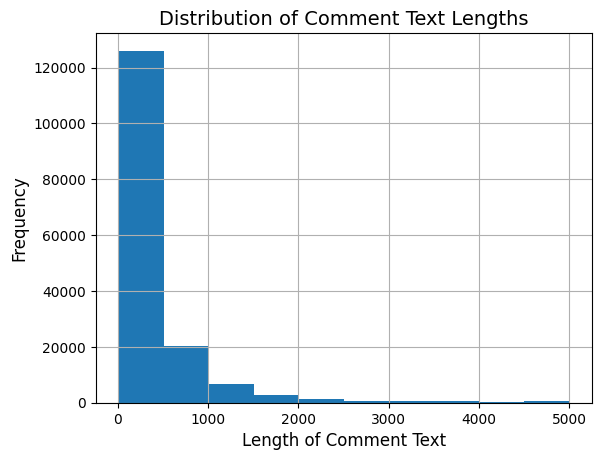

In [10]:
# Plot the histogram of the lengths of the comment text
lens = train.comment_text.str.len()
lens.hist()
plt.xlabel('Length of Comment Text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Comment Text Lengths', fontsize=14)
plt.show()


In [11]:
#LABELS COUNT
x = train.iloc[:, 2:].sum()
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [12]:
#Total label in each row
rowsums = train.iloc[:, 2:].sum(axis=1)
print('Total label of each comment')
print(rowsums)

#Comment with/ without labels
no_label_count = 0
for i, count in rowsums.items():
    if count==0:
        no_label_count += 1

print('Total number of comments:', len(train))
print('Total number of comments without labels:', no_label_count)
print('Total labels:', x.sum())

Total label of each comment
0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64
Total number of comments: 159571
Total number of comments without labels: 143346
Total labels: 35098


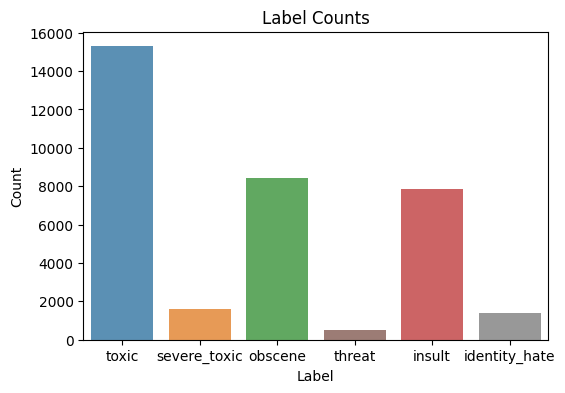

In [13]:
#LABELS COUNT PLOT
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Label Counts')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

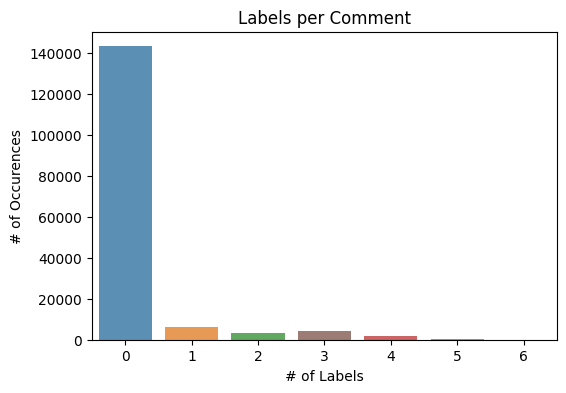

In [14]:
#LABELS PER COMMENT PLOT
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Labels per Comment')
plt.ylabel('# of Occurences')
plt.xlabel('# of Labels')

plt.show()

# **Preprocessing the data**

In [15]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

def tokenize(text):
#Tokenize text and return a non-unique list of tokenized words found in the text.
#Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
#Lemmatize the words
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    return words


In [16]:
#Preprocess the comment
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
#split for training data
train = train.drop(columns=['id'], axis=1)
X = train['comment_text']
y = train.drop(columns=['comment_text'], axis=1)

In [18]:
# Split the data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# **Tokenize and clean data**

In [19]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf= True, min_df=10)
# Fit the vectorizer on the training data and transform the data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Output the shapes of the resulting matrices
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(111699, 15785)
(47872, 15785)


# **Naive Bayes as benchmark**

In [20]:
# Initialize the MultinomialNB classifier
nb = MultinomialNB()
# Use OneVsRestClassifier for multilabel classification
clf = OneVsRestClassifier(nb)
# Train the model on the training data
clf.fit(X_train_tfidf, y_train)
# Make predictions on the test data
y_pred = clf.predict(X_test_tfidf)
# Evaluate the model using accuracy and classification report
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy Score:  0.9068766711229946
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.40      0.57      4582
           1       0.58      0.01      0.03       486
           2       0.94      0.36      0.52      2556
           3       0.00      0.00      0.00       136
           4       0.85      0.27      0.41      2389
           5       0.00      0.00      0.00       432

   micro avg       0.92      0.32      0.48     10581
   macro avg       0.55      0.17      0.25     10581
weighted avg       0.86      0.32      0.46     10581
 samples avg       0.04      0.03      0.03     10581



# **Random forest solution**

In [21]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Use OneVsRestClassifier for multilabel classification
clf = OneVsRestClassifier(rf)
# Train the model on the training data
clf.fit(X_train_tfidf, y_train)
# Make predictions on the test data
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model using accuracy and classification report
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score:  0.9160469585561497
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.64      0.74      4582
           1       0.46      0.07      0.12       486
           2       0.88      0.70      0.78      2556
           3       0.38      0.04      0.07       136
           4       0.76      0.53      0.63      2389
           5       0.83      0.11      0.20       432

   micro avg       0.84      0.57      0.68     10581
   macro avg       0.70      0.35      0.42     10581
weighted avg       0.82      0.57      0.66     10581
 samples avg       0.06      0.05      0.05     10581



# **Support vector machine solution**

In [22]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm = SVC(kernel='linear', random_state=42)

# Use OneVsRestClassifier for multilabel classification
clf_svm = OneVsRestClassifier(svm)

# Train the model on the training data
clf_svm.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred_svm = clf_svm.predict(X_test_tfidf)

# Evaluate the model using accuracy and classification report
print("SVM Accuracy Score: ", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy Score:  0.9199532085561497
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75      4582
           1       0.80      0.05      0.09       486
           2       0.91      0.67      0.77      2556
           3       0.77      0.07      0.13       136
           4       0.80      0.55      0.65      2389
           5       0.87      0.13      0.23       432

   micro avg       0.88      0.57      0.69     10581
   macro avg       0.84      0.35      0.44     10581
weighted avg       0.87      0.57      0.67     10581
 samples avg       0.06      0.05      0.05     10581



# **Logistic regression solution**

In [23]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Use OneVsRestClassifier for multilabel classification
clf_log_reg = OneVsRestClassifier(log_reg)

# Train the model on the training data
clf_log_reg.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred_log_reg = clf_log_reg.predict(X_test_tfidf)

# Evaluate the model using accuracy and classification report
print("Logistic Regression Accuracy Score: ", accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))


Logistic Regression Accuracy Score:  0.9176763034759359
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.57      0.71      4582
           1       0.57      0.23      0.33       486
           2       0.92      0.59      0.72      2556
           3       0.64      0.10      0.18       136
           4       0.82      0.48      0.61      2389
           5       0.75      0.16      0.27       432

   micro avg       0.89      0.52      0.65     10581
   macro avg       0.77      0.36      0.47     10581
weighted avg       0.87      0.52      0.65     10581
 samples avg       0.05      0.04      0.05     10581

